In [1]:
import os
import glob
from skimage.transform import warp, ProjectiveTransform
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
path = "1/hpatches-sequences-release/"
validation_data_base = []
for dirs in os.listdir(path):
    current_set = []
    # I'm interested only in prespective changes so I chose only view point sets not intensity
    if dirs.startswith("i"): continue
    img_path1 = path + dirs + "/1.ppm"
    for i in range(2, 7):
        img_path2 = path + dirs + f"/{i}.ppm"
        transformation = path + dirs + f"/H_{1}_{i}"
        current_set.append((img_path1, img_path2, transformation))
    validation_data_base.append(current_set)

In [2]:
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)

/home/20223176/.local/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
2025-04-01 16:13:11.695868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

In [4]:
def apply_homography(image, H):
    h, w = image.shape[:2]
    return cv2.warpPerspective(image, H, (w, h))

def extract_keypoints_and_matches(image0, image1, extractor, matcher):
    feats0 = extractor.extract(image0)
    feats1 = extractor.extract(image1)
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    return m_kpts0.cpu().numpy(), m_kpts1.cpu().numpy(), matches01

def extract_patches(image, keypoints, patch_size=32):
    patches = []
    h, w = image.shape[:2]
    half = patch_size // 2
    for (x, y) in keypoints:
        x, y = int(x), int(y)
        x1, y1 = max(0, x - half), max(0, y - half)
        x2, y2 = min(w, x + half), min(h, y + half)
        patch = image[y1:y2, x1:x2]
        patch = cv2.resize(patch, (patch_size, patch_size))
        patch = patch.astype(np.float32) / 255.0
        if patch.ndim == 3 and patch.shape[2] == 3:
            patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
        patches.append(patch)
    return np.array(patches)

In [4]:
patch_size = 30
num_train_images = 50

In [12]:
import torch
import cv2
import numpy as np
import random
import os
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

extractor = SuperPoint().to(device)
matcher = LightGlue().to(device)

random.shuffle(validation_data_base)
train_data = validation_data_base[:num_train_images]
val_data = validation_data_base[num_train_images:]

train_patches0, train_patches1, train_offsets = [], [], []
val_patches0, val_patches1, val_offsets = [], [], []

def process_image_pairs(data, patches0_list, patches1_list, offsets_list):
    for image_set in data:
        for (img1_path, img2_path, tr_path) in image_set:
            img1 = cv2.imread(img1_path)  
            img2 = cv2.imread(img2_path)
            transformation = np.loadtxt(tr_path)

            image0_torch = torch.from_numpy(img1.astype(np.float32) / 255.0).permute(2,0,1).unsqueeze(0).to(device)
            image1_torch = torch.from_numpy(img2.astype(np.float32) / 255.0).permute(2,0,1).unsqueeze(0).to(device)

            m_kpts0, m_kpts1, matches01 = extract_keypoints_and_matches(image0_torch, image1_torch, extractor, matcher)

            if m_kpts0.shape[0] == 0:
                continue

            ones = np.ones((m_kpts0.shape[0], 1), dtype=np.float32)
            kpts0_homogeneous = np.hstack([m_kpts0, ones])   
            kpts1_gt = (transformation @ kpts0_homogeneous.T).T 
            kpts1_gt[:, :2] /= kpts1_gt[:, 2:].copy()
            kpts1_gt = kpts1_gt[:, :2]

            offsets = kpts1_gt - m_kpts1  
            error = np.linalg.norm(offsets, axis=1)  

            patches0 = extract_patches(img1, m_kpts0, patch_size=patch_size) 
            patches1 = extract_patches(img2, m_kpts1, patch_size=patch_size) 

            if patches0.shape[0] > 0 and patches1.shape[0] > 0 and patches0.shape[0] == offsets.shape[0]:
                patches0_list.append(patches0)
                patches1_list.append(patches1)
                offsets_list.append(offsets)

process_image_pairs(train_data, train_patches0, train_patches1, train_offsets)

process_image_pairs(val_data, val_patches0, val_patches1, val_offsets)

train_patches0_array = np.concatenate(train_patches0, axis=0) if train_patches0 else np.empty((0, patch_size, patch_size))
train_patches1_array = np.concatenate(train_patches1, axis=0) if train_patches1 else np.empty((0, patch_size, patch_size))
train_offsets_array  = np.concatenate(train_offsets, axis=0) if train_offsets else np.empty((0, 2))

val_patches0_array = np.concatenate(val_patches0, axis=0) if val_patches0 else np.empty((0, patch_size, patch_size))
val_patches1_array = np.concatenate(val_patches1, axis=0) if val_patches1 else np.empty((0, patch_size, patch_size))
val_offsets_array  = np.concatenate(val_offsets, axis=0) if val_offsets else np.empty((0, 2))

np.savez("homography_train_dataset_50.npz",
         patches0=train_patches0_array,
         patches1=train_patches1_array,
         offsets=train_offsets_array)
np.savez("homography_val_dataset_50.npz",
         patches0=val_patches0_array,
         patches1=val_patches1_array,
         offsets=val_offsets_array)

print(f"학습 데이터 저장 완료. (patch size={patch_size})")
print(f"검증 데이터 저장 완료. (patch size={patch_size})")



학습 데이터 저장 완료. (patch size=50)
검증 데이터 저장 완료. (patch size=50)


In [5]:
torch.set_grad_enabled(True)

In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset

# class SinglePatchDataset(Dataset):
#     def __init__(self, npz_path):
#         data = np.load(npz_path)
#         self.patches0 = data["patches0"]  
#         self.offsets = data["offsets"]   
#     def __len__(self):
#         return len(self.offsets)

#     def __getitem__(self, idx):

#         patch0 = self.patches0[idx]
#         offset = self.offsets[idx] 


#         patch_tensor = torch.from_numpy(patch0).unsqueeze(0).float() 
#         offset_tensor = torch.from_numpy(offset).float()              

#         return patch_tensor, offset_tensor
# class DualPatchDataset(Dataset):
#     def __init__(self, npz_path):
#         data = np.load(npz_path)
#         self.patches0 = data["patches0"]  
#         self.patches1 = data["patches1"]  
#         self.offsets = data["offsets"]    
        
#     def __len__(self):
#         return len(self.offsets)

#     def __getitem__(self, idx):
#         patch0 = self.patches0[idx]  
#         patch1 = self.patches1[idx]

#         offset = self.offsets[idx]   

#         patch_pair = np.stack([patch0, patch1, patch1-patch0], axis=0)

#         patch_tensor = torch.from_numpy(patch_pair).float() 
#         offset_tensor = torch.from_numpy(offset).float()

#         return patch_tensor, offset_tensor
def crop_patch_centered(image, center, size):
    """
    image: numpy array, shape (H, W)
    center: tuple or array-like (x, y) keypoint 좌표 (픽셀 단위)
    size: int, 추출할 정사각형 패치의 크기 (예: 8, 20)
    """
    H, W = image.shape
    half_size = size // 2
    cx, cy = int(round(center[0])), int(round(center[1]))
    
    start_x = cx - half_size
    start_y = cy - half_size
    end_x = start_x + size
    end_y = start_y + size

    pad_left = max(0, -start_x)
    pad_top = max(0, -start_y)
    pad_right = max(0, end_x - W)
    pad_bottom = max(0, end_y - H)
    
    if pad_left or pad_top or pad_right or pad_bottom:
        image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
        start_x += pad_left
        start_y += pad_top
        end_x += pad_left
        end_y += pad_top

    return image[start_y:end_y, start_x:end_x]

class DualPatchDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path)
        self.patches0 = data["patches0"]  
        self.patches1 = data["patches1"]  
        self.offsets = data["offsets"]    

    def __len__(self):
        return len(self.offsets)

    def __getitem__(self, idx):
        patch0 = self.patches0[idx]  
        patch1 = self.patches1[idx]  
        offset = self.offsets[idx]   

        patch_pair = np.stack([patch0, patch1], axis=0)

        patch_tensor = torch.from_numpy(patch_pair).float() 
        offset_tensor = torch.from_numpy(offset).float()

        return patch_tensor, offset_tensor


import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class KeypointRefiner(nn.Module):
    def __init__(self, in_channels=2,patch_size=30, offset_threshold=5.0):
        super().__init__()
        self.offset_threshold = offset_threshold  # 큰 오차를 가진 keypoint는 특별 처리

        self.layer1 = ResNetBasicBlock(in_channels, 32)
        self.layer2 = ResNetBasicBlock(32, 64, stride=2)
        self.layer3 = ResNetBasicBlock(64, 128, stride=2)

        self.fc1 = None
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x, offsets=None):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = x.view(x.size(0), -1)

        if self.fc1 is None:
            input_dim = x.shape[1]
            self.fc1 = nn.Linear(input_dim, 256).to(x.device)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        pred_offsets = self.fc3(x)

        # 큰 오차를 가진 keypoint 보정
        if offsets is not None:
            error = torch.norm(pred_offsets - offsets, dim=1)
            mask = error < self.offset_threshold
            pred_offsets = mask.unsqueeze(1) * pred_offsets + (1 - mask).unsqueeze(1) * offsets  

        return pred_offsets



In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class AdaptiveKeypointRefiner(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.layer1 = ResNetBasicBlock(in_channels, 32, stride=1)
        self.layer2 = ResNetBasicBlock(32, 64, stride=2)
        self.layer3 = ResNetBasicBlock(64, 128, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        self.fc = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.global_pool(x)  
        x = x.view(x.size(0), -1)  # (N, 128)

        out = self.fc(x)  # (N, 2)
        return out


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class DualPathwayKeypointRefiner(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.small_patch_resnet = self._get_resnet_model(in_channels)
        self.large_patch_resnet = self._get_resnet_model(in_channels)

        self.fc = nn.Linear(512 * 2, 2)  

    def _get_resnet_model(self, in_channels):
        layers = []
        layers.append(ResNetBasicBlock(in_channels, 64))  
        layers.append(ResNetBasicBlock(64, 128, stride=2))  
        layers.append(ResNetBasicBlock(128, 256, stride=2))  
        layers.append(ResNetBasicBlock(256, 512, stride=2)) 

        return nn.Sequential(*layers)
    def forward(self, patch_small, patch_large):
        small_features = self.small_patch_resnet(patch_small)
        small_features = F.adaptive_avg_pool2d(small_features, (1, 1))
        small_features = small_features.view(small_features.size(0), -1)

        large_features = self.large_patch_resnet(patch_large)
        large_features = F.adaptive_avg_pool2d(large_features, (1, 1))
        large_features = large_features.view(large_features.size(0), -1)

        combined = torch.cat([small_features, large_features], dim=1)
        out = self.fc(combined)
        return out




In [7]:
from torch.utils.data import DataLoader
import torch.optim as optim

train_ds = DualPatchDataset("homography_train_dataset_30.npz")
val_ds   = DualPatchDataset("homography_val_dataset_30.npz")

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KeypointRefiner(in_channels=2, patch_size=patch_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.HuberLoss(delta=1.0) 


epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for patches, offsets in train_loader:
        patches = patches.to(device)   
        offsets = offsets.to(device)   
        
        optimizer.zero_grad()
        pred_offsets = model(patches)  
        loss = criterion(pred_offsets, offsets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for patches, offsets in val_loader:
            patches = patches.to(device)
            offsets = offsets.to(device)
            pred_offsets = model(patches)
            weights = torch.norm(pred_offsets - offsets, dim=1).clamp(min=0.1)  # 오차가 큰 경우 가중치 낮춤

            loss = (weights * criterion(pred_offsets, offsets)).mean()
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch [1/100] | Train Loss: 0.8367 | Val Loss: 160.6679
Epoch [2/100] | Train Loss: 0.7443 | Val Loss: 160.4607
Epoch [3/100] | Train Loss: 0.7181 | Val Loss: 160.4423
Epoch [4/100] | Train Loss: 0.7010 | Val Loss: 160.8992
Epoch [5/100] | Train Loss: 0.6877 | Val Loss: 160.6472
Epoch [6/100] | Train Loss: 0.6775 | Val Loss: 160.7384
Epoch [7/100] | Train Loss: 0.6685 | Val Loss: 160.7470
Epoch [8/100] | Train Loss: 0.6608 | Val Loss: 160.4721
Epoch [9/100] | Train Loss: 0.6542 | Val Loss: 160.2413
Epoch [10/100] | Train Loss: 0.6475 | Val Loss: 160.3178
Epoch [11/100] | Train Loss: 0.6414 | Val Loss: 160.7216
Epoch [12/100] | Train Loss: 0.6372 | Val Loss: 160.7248
Epoch [13/100] | Train Loss: 0.6323 | Val Loss: 160.3734
Epoch [14/100] | Train Loss: 0.6277 | Val Loss: 160.5007
Epoch [15/100] | Train Loss: 0.6234 | Val Loss: 160.7960
Epoch [16/100] | Train Loss: 0.6204 | Val Loss: 160.5562
Epoch [17/100] | Train Loss: 0.6160 | Val Loss: 160.6882
Epoch [18/100] | Train Loss: 0.6127 | Va

In [24]:
from torch.utils.data import DataLoader
import torch.optim as optim

train_ds = DualPatchDataset("homography_train_dataset_50.npz")
val_ds   = DualPatchDataset("homography_val_dataset_50.npz")

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualPathwayKeypointRefiner(in_channels=3).to(device)  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.SmoothL1Loss()

epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for patch_small, patch_large, offsets in train_loader:
        patch_small = patch_small.to(device)
        patch_large = patch_large.to(device)
        offsets = offsets.to(device)

        optimizer.zero_grad()
        pred_offsets = model(patch_small, patch_large)
        loss = criterion(pred_offsets, offsets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for patch_small, patch_large, offsets in val_loader:
            patch_small = patch_small.to(device)
            patch_large = patch_large.to(device)
            offsets = offsets.to(device)
            pred_offsets = model(patch_small, patch_large)
            val_loss += criterion(pred_offsets, offsets).item()
    scheduler.step(val_loss)

    val_loss /= len(val_loader)
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    


Epoch [1/100] | Train Loss: 1.0769 | Val Loss: 0.9491
Epoch [2/100] | Train Loss: 1.0723 | Val Loss: 0.9494
Epoch [3/100] | Train Loss: 1.0708 | Val Loss: 0.9488
Epoch [4/100] | Train Loss: 1.0707 | Val Loss: 0.9494
Epoch [5/100] | Train Loss: 1.0706 | Val Loss: 0.9503
Epoch [6/100] | Train Loss: 1.0708 | Val Loss: 0.9502
Epoch [7/100] | Train Loss: 1.0705 | Val Loss: 0.9501
Epoch [8/100] | Train Loss: 1.0704 | Val Loss: 0.9499
Epoch [9/100] | Train Loss: 1.0702 | Val Loss: 0.9516
Epoch [10/100] | Train Loss: 1.0700 | Val Loss: 0.9569
Epoch [11/100] | Train Loss: 1.0698 | Val Loss: 0.9505
Epoch [12/100] | Train Loss: 1.0692 | Val Loss: 0.9519
Epoch [13/100] | Train Loss: 1.0685 | Val Loss: 0.9529
Epoch [14/100] | Train Loss: 1.0672 | Val Loss: 0.9523
Epoch [15/100] | Train Loss: 1.0654 | Val Loss: 0.9572
Epoch [16/100] | Train Loss: 1.0625 | Val Loss: 0.9610
Epoch [17/100] | Train Loss: 1.0583 | Val Loss: 0.9712
Epoch [18/100] | Train Loss: 1.0526 | Val Loss: 0.9723
Epoch [19/100] | Tr

In [33]:
print(patch_small.shape)  # (B, C, H, W) 형태로 출력되어야 함
print(patch_large.shape)


torch.Size([64, 1, 24, 8])
torch.Size([64, 1, 60, 20])


In [13]:
PATH = "./resnet_patch_Siamese_stack_patch_50.pth"
torch.save(model, PATH)

In [8]:
model = torch.load(PATH)

/tmp/ipykernel_10438/3217080089.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(PATH)


In [17]:
random.shuffle(validation_data_base)
for image_set in validation_data_base:
    for img1_path, img2_path, tr_path in image_set:
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)   
        transformation = np.loadtxt(tr_path)
        break
    break

In [52]:
import numpy as np
import torch
import cv2

def refine_keypoints_with_model(
    img1, img2,
    m_kpts0, m_kpts1,
    model,
    patch_size=16,
    device='cuda'
):
    model.eval()
    corrected_kpts1 = []

    for kp0, kp1 in zip(m_kpts0, m_kpts1):
        patch0 = extract_single_patch(img1, kp0, patch_size)
        patch1 = extract_single_patch(img2, kp1, patch_size)
        patch0_tensor =  torch.from_numpy(patch0).unsqueeze(0).float()
        patch1_tensor =  torch.from_numpy(patch1).unsqueeze(0).float()
        # patch_pair = np.stack([patch0, patch1, patch1-patch0], axis=0)  
        # patch_tensor = torch.from_numpy(patch_pair).unsqueeze(0).float()
        # patch_tensor = patch_tensor.to(device)
        patch0_tensor = patch0_tensor.to(device)
        patch1_tensor = patch1_tensor.to(device)
        with torch.no_grad():
            pred_offset = model(patch0_tensor, patch1_tensor) 
        offset_np = pred_offset[0].cpu().numpy()

        kp1_corrected = kp1 + offset_np
        corrected_kpts1.append(kp1_corrected)

    return np.array(corrected_kpts1)

def extract_single_patch(image, keypoint, patch_size=8):
    x, y = int(keypoint[0]), int(keypoint[1])
    half = patch_size // 2
    h, w = image.shape[:2]

    x1, x2 = max(0, x-half), min(w, x+half)
    y1, y2 = max(0, y-half), min(h, y+half)

    patch = image[y1:y2, x1:x2]
    patch = cv2.resize(patch, (patch_size, patch_size))
    patch = patch.astype(np.float32) / 255.0

    if patch.ndim == 3 and patch.shape[2] == 3:
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

    return patch 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
def compute_refinement_error(gt_kpts, refined_kpts):
    distances = np.linalg.norm(gt_kpts - refined_kpts, axis=1)
    mean_error = np.mean(distances)
    std_error = np.std(distances)
    return mean_error, std_error


def process_validation_data(validation_data_base, extractor, matcher, model, patch_size=16, device='cuda'):
    all_mean_errors_before = []
    all_std_errors_before = []
    all_mean_errors_after = []
    all_std_errors_after = []
    
    for image_set in validation_data_base:
        for img1_path, img2_path, tr_path in image_set:
            img1 = cv2.imread(img1_path)
            img2 = cv2.imread(img2_path)   
            transformation = np.loadtxt(tr_path)
            
            image1_torch = torch.from_numpy(img1.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)
            image2_torch = torch.from_numpy(img2.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)
            
            feats0 = extractor.extract(image1_torch)
            feats1 = extractor.extract(image2_torch)
            matches01 = matcher({"image0": feats0, "image1": feats1})
            feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
            
            kpts0 = feats0["keypoints"].cpu().numpy()
            kpts1 = feats1["keypoints"].cpu().numpy()
            matches = matches01["matches"]
            if isinstance(matches, torch.Tensor):
                matches = matches.cpu().numpy()
            
            m_kpts0 = kpts0[matches[:, 0]]
            m_kpts1 = kpts1[matches[:, 1]]
            
            ones = np.ones((m_kpts0.shape[0], 1), dtype=np.float32)
            kpts0_homogeneous = np.hstack([m_kpts0, ones])  
            kpts1_gt = (transformation @ kpts0_homogeneous.T).T  
            kpts1_gt[:, :2] /= kpts1_gt[:, 2:].copy()
            kpts1_gt = kpts1_gt[:, :2]  
            
            refined_kpts1 = refine_keypoints_with_model(
                img1, img2, m_kpts0, m_kpts1,
                model=model,
                patch_size=patch_size,
                device=device
            )
            
            mean_err_before, std_err_before = compute_refinement_error(kpts1_gt, m_kpts1)
            mean_err_after, std_err_after = compute_refinement_error(kpts1_gt, refined_kpts1)
            
            all_mean_errors_before.append(mean_err_before)
            all_std_errors_before.append(std_err_before)
            all_mean_errors_after.append(mean_err_after)
            all_std_errors_after.append(std_err_after)
            
    return (
        np.mean(all_mean_errors_before), np.std(all_std_errors_before),
        np.mean(all_mean_errors_after), np.std(all_std_errors_after)
    )

mean_before, std_before, mean_after, std_after = process_validation_data(validation_data_base, extractor, matcher, model ,patch_size=patch_size)
print(f"Before refinement - Mean error: {mean_before:.2f} pixels, Std error: {std_before:.2f} pixels")
print(f"After refinement - Mean error: {mean_after:.2f} pixels, Std error: {std_after:.2f} pixels")


Before refinement - Mean error: 11.80 pixels, Std error: 21.63 pixels
After refinement - Mean error: 11.01 pixels, Std error: 21.64 pixels


In [47]:
model2 = torch.load("resnet_patch_difference_stack.pth")
import numpy as np
import torch
import cv2

def refine_keypoints_with_model(
    img1, img2,
    m_kpts0, m_kpts1,
    model,
    patch_size=16,
    device='cuda'
):
    model.eval()
    corrected_kpts1 = []

    for kp0, kp1 in zip(m_kpts0, m_kpts1):
        patch0 = extract_single_patch(img1, kp0, patch_size)
        patch1 = extract_single_patch(img2, kp1, patch_size)

        patch_pair = np.stack([patch0, patch1, patch1-patch0], axis=0)  
        patch_tensor = torch.from_numpy(patch_pair).unsqueeze(0).float()
        patch_tensor = patch_tensor.to(device)

        with torch.no_grad():
            pred_offset = model(patch_tensor) 
        offset_np = pred_offset[0].cpu().numpy()

        kp1_corrected = kp1 + offset_np
        corrected_kpts1.append(kp1_corrected)

    return np.array(corrected_kpts1)

def extract_single_patch(image, keypoint, patch_size=8):
    x, y = int(keypoint[0]), int(keypoint[1])
    half = patch_size // 2
    h, w = image.shape[:2]

    x1, x2 = max(0, x-half), min(w, x+half)
    y1, y2 = max(0, y-half), min(h, y+half)

    patch = image[y1:y2, x1:x2]
    patch = cv2.resize(patch, (patch_size, patch_size))
    patch = patch.astype(np.float32) / 255.0

    if patch.ndim == 3 and patch.shape[2] == 3:
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

    return patch 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
def compute_refinement_error(gt_kpts, refined_kpts):
    distances = np.linalg.norm(gt_kpts - refined_kpts, axis=1)
    mean_error = np.mean(distances)
    std_error = np.std(distances)
    return mean_error, std_error


def process_validation_data(validation_data_base, extractor, matcher, model, patch_size=16, device='cuda'):
    all_mean_errors_before = []
    all_std_errors_before = []
    all_mean_errors_after = []
    all_std_errors_after = []
    
    for image_set in validation_data_base:
        for img1_path, img2_path, tr_path in image_set:
            img1 = cv2.imread(img1_path)
            img2 = cv2.imread(img2_path)   
            transformation = np.loadtxt(tr_path)
            
            image1_torch = torch.from_numpy(img1.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)
            image2_torch = torch.from_numpy(img2.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)
            
            feats0 = extractor.extract(image1_torch)
            feats1 = extractor.extract(image2_torch)
            matches01 = matcher({"image0": feats0, "image1": feats1})
            feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
            
            kpts0 = feats0["keypoints"].cpu().numpy()
            kpts1 = feats1["keypoints"].cpu().numpy()
            matches = matches01["matches"]
            if isinstance(matches, torch.Tensor):
                matches = matches.cpu().numpy()
            
            m_kpts0 = kpts0[matches[:, 0]]
            m_kpts1 = kpts1[matches[:, 1]]
            
            ones = np.ones((m_kpts0.shape[0], 1), dtype=np.float32)
            kpts0_homogeneous = np.hstack([m_kpts0, ones])  
            kpts1_gt = (transformation @ kpts0_homogeneous.T).T  
            kpts1_gt[:, :2] /= kpts1_gt[:, 2:].copy()
            kpts1_gt = kpts1_gt[:, :2]  
            
            refined_kpts1 = refine_keypoints_with_model(
                img1, img2, m_kpts0, m_kpts1,
                model=model,
                patch_size=patch_size,
                device=device
            )
            
            mean_err_before, std_err_before = compute_refinement_error(kpts1_gt, m_kpts1)
            mean_err_after, std_err_after = compute_refinement_error(kpts1_gt, refined_kpts1)
            
            all_mean_errors_before.append(mean_err_before)
            all_std_errors_before.append(std_err_before)
            all_mean_errors_after.append(mean_err_after)
            all_std_errors_after.append(std_err_after)
            
    return (
        np.mean(all_mean_errors_before), np.std(all_std_errors_before),
        np.mean(all_mean_errors_after), np.std(all_std_errors_after)
    )

mean_before, std_before, mean_after, std_after = process_validation_data(validation_data_base, extractor, matcher, model2 ,patch_size=10)
print(f"Before refinement - Mean error: {mean_before:.2f} pixels, Std error: {std_before:.2f} pixels")
print(f"After refinement - Mean error: {mean_after:.2f} pixels, Std error: {std_after:.2f} pixels")

/tmp/ipykernel_6745/2837514356.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2 = torch.load("resnet_patch_difference_stack.pth")

KeyboardInterrupt



In [19]:
# model3 = torch.load("resnet_patch_stack.pth")
import numpy as np
import torch
import cv2

def refine_keypoints_with_model(
    img1, img2,
    m_kpts0, m_kpts1,
    model,
    patch_size=16,
    device='cuda'
):
    model.eval()
    corrected_kpts1 = []

    for kp0, kp1 in zip(m_kpts0, m_kpts1):
        patch0 = extract_single_patch(img1, kp0, patch_size)
        patch1 = extract_single_patch(img2, kp1, patch_size)

        patch_pair = np.stack([patch0, patch1], axis=0)  
        patch_tensor = torch.from_numpy(patch_pair).unsqueeze(0).float()
        patch_tensor = patch_tensor.to(device)

        with torch.no_grad():
            pred_offset = model(patch_tensor) 
        offset_np = pred_offset[0].cpu().numpy()

        kp1_corrected = kp1 + offset_np
        corrected_kpts1.append(kp1_corrected)

    return np.array(corrected_kpts1)

def extract_single_patch(image, keypoint, patch_size=8):
    x, y = int(keypoint[0]), int(keypoint[1])
    half = patch_size // 2
    h, w = image.shape[:2]

    x1, x2 = max(0, x-half), min(w, x+half)
    y1, y2 = max(0, y-half), min(h, y+half)

    patch = image[y1:y2, x1:x2]
    patch = cv2.resize(patch, (patch_size, patch_size))
    patch = patch.astype(np.float32) / 255.0

    if patch.ndim == 3 and patch.shape[2] == 3:
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

    return patch 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
def compute_refinement_error(gt_kpts, refined_kpts):
    distances = np.linalg.norm(gt_kpts - refined_kpts, axis=1)
    mean_error = np.mean(distances)
    std_error = np.std(distances)
    return mean_error, std_error


def process_validation_data(validation_data_base, extractor, matcher, model, patch_size=16, device='cuda'):
    all_mean_errors_before = []
    all_std_errors_before = []
    all_mean_errors_after = []
    all_std_errors_after = []
    
    for image_set in validation_data_base:
        for img1_path, img2_path, tr_path in image_set:
            img1 = cv2.imread(img1_path)
            img2 = cv2.imread(img2_path)   
            transformation = np.loadtxt(tr_path)
            
            image1_torch = torch.from_numpy(img1.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)
            image2_torch = torch.from_numpy(img2.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)
            
            feats0 = extractor.extract(image1_torch)
            feats1 = extractor.extract(image2_torch)
            matches01 = matcher({"image0": feats0, "image1": feats1})
            feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
            
            kpts0 = feats0["keypoints"].cpu().numpy()
            kpts1 = feats1["keypoints"].cpu().numpy()
            matches = matches01["matches"]
            if isinstance(matches, torch.Tensor):
                matches = matches.cpu().numpy()
            
            m_kpts0 = kpts0[matches[:, 0]]
            m_kpts1 = kpts1[matches[:, 1]]
            
            ones = np.ones((m_kpts0.shape[0], 1), dtype=np.float32)
            kpts0_homogeneous = np.hstack([m_kpts0, ones])  
            kpts1_gt = (transformation @ kpts0_homogeneous.T).T  
            kpts1_gt[:, :2] /= kpts1_gt[:, 2:].copy()
            kpts1_gt = kpts1_gt[:, :2]  
            
            refined_kpts1 = refine_keypoints_with_model(
                img1, img2, m_kpts0, m_kpts1,
                model=model,
                patch_size=patch_size,
                device=device
            )
            
            mean_err_before, std_err_before = compute_refinement_error(kpts1_gt, m_kpts1)
            mean_err_after, std_err_after = compute_refinement_error(kpts1_gt, refined_kpts1)
            
            all_mean_errors_before.append(mean_err_before)
            all_std_errors_before.append(std_err_before)
            all_mean_errors_after.append(mean_err_after)
            all_std_errors_after.append(std_err_after)
            
    return (
        np.mean(all_mean_errors_before), np.std(all_std_errors_before),
        np.mean(all_mean_errors_after), np.std(all_std_errors_after)
    )

mean_before, std_before, mean_after, std_after = process_validation_data(validation_data_base, extractor, matcher, model ,patch_size=patch_size)
print(f"Before refinement - Mean error: {mean_before:.2f} pixels, Std error: {std_before:.2f} pixels")
print(f"After refinement - Mean error: {mean_after:.2f} pixels, Std error: {std_after:.2f} pixels")

Before refinement - Mean error: 11.33 pixels, Std error: 22.67 pixels
After refinement - Mean error: 10.41 pixels, Std error: 22.71 pixels


In [16]:
import numpy as np
import torch
import cv2
import torch.nn.functional as F

def refine_keypoints_with_model(
    img1, img2,
    m_kpts0, m_kpts1,
    model,
    patch_size=16,
    device='cuda'
):
    model.eval()
    corrected_kpts1 = []

    for kp0, kp1 in zip(m_kpts0, m_kpts1):
        # 각 이미지에서 키포인트 위치 주변의 패치를 추출합니다.
        patch0 = extract_single_patch(img1, kp0, patch_size)
        patch1 = extract_single_patch(img2, kp1, patch_size)
        
        # 추출된 patch는 grayscale로 (patch_size, patch_size) shape를 가집니다.
        # 모델 입력을 위해 채널 차원 추가 → (1, patch_size, patch_size)
        if patch0.ndim == 2:
            patch0 = np.expand_dims(patch0, axis=0)
        else:
            # 컬러인 경우: (H,W,3) -> (3,H,W)
            patch0 = np.transpose(patch0, (2, 0, 1))
            
        if patch1.ndim == 2:
            patch1 = np.expand_dims(patch1, axis=0)
        else:
            patch1 = np.transpose(patch1, (2, 0, 1))
        
        # 배치 차원 추가: (1, C, H, W)
        patch0_tensor = torch.from_numpy(patch0).unsqueeze(0).float().to(device)
        patch1_tensor = torch.from_numpy(patch1).unsqueeze(0).float().to(device)
        
        with torch.no_grad():
            # 모델은 두 패치를 받아 채널 방향으로 결합한 후 오프셋을 예측합니다.
            # 예: 입력 (patch_small, patch_large) → 내부적으로 torch.cat([patch_small, patch_large], dim=1)
            pred_offset = model(patch0_tensor, patch1_tensor)

        offset_np = pred_offset[0].cpu().numpy()  # (2,) shape: (dx, dy)
        
        kp1_corrected = kp1 + offset_np
        corrected_kpts1.append(kp1_corrected)

    return np.array(corrected_kpts1)


def extract_single_patch(image, keypoint, patch_size=16):
    x, y = int(keypoint[0]), int(keypoint[1])
    half = patch_size // 2
    h, w = image.shape[:2]

    x1, x2 = max(0, x - half), min(w, x + half)
    y1, y2 = max(0, y - half), min(h, y + half)

    patch = image[y1:y2, x1:x2]
    patch = cv2.resize(patch, (patch_size, patch_size))
    patch = patch.astype(np.float32) / 255.0

    # 만약 patch가 이미 컬러라면 그대로 사용, 그레이스케일이면 3채널로 복제
    if patch.ndim == 2:
        patch = np.stack([patch, patch, patch], axis=-1)
    elif patch.ndim == 3 and patch.shape[2] != 3:
        patch = cv2.cvtColor(patch, cv2.COLOR_GRAY2BGR)
    
    return patch



def compute_refinement_error(gt_kpts, refined_kpts):
    distances = np.linalg.norm(gt_kpts - refined_kpts, axis=1)
    mean_error = np.mean(distances)
    std_error = np.std(distances)
    return mean_error, std_error


def process_validation_data(validation_data_base, extractor, matcher, model, patch_size=16, device='cuda'):
    all_mean_errors_before = []
    all_std_errors_before = []
    all_mean_errors_after = []
    all_std_errors_after = []
    
    for image_set in validation_data_base:
        for img1_path, img2_path, tr_path in image_set:
            img1 = cv2.imread(img1_path)
            img2 = cv2.imread(img2_path)   
            transformation = np.loadtxt(tr_path)
            
            # 이미지 정규화 및 torch tensor 변환 (컬러 이미지의 경우, 3채널)
            image1_torch = torch.from_numpy(img1.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)
            image2_torch = torch.from_numpy(img2.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)
            
            feats0 = extractor.extract(image1_torch)
            feats1 = extractor.extract(image2_torch)
            matches01 = matcher({"image0": feats0, "image1": feats1})
            feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
            
            kpts0 = feats0["keypoints"].cpu().numpy()
            kpts1 = feats1["keypoints"].cpu().numpy()
            matches = matches01["matches"]
            if isinstance(matches, torch.Tensor):
                matches = matches.cpu().numpy()
            
            m_kpts0 = kpts0[matches[:, 0]]
            m_kpts1 = kpts1[matches[:, 1]]
            
            # GT: transformation matrix를 이용해 img1의 키포인트를 img2의 좌표계로 변환
            ones = np.ones((m_kpts0.shape[0], 1), dtype=np.float32)
            kpts0_homogeneous = np.hstack([m_kpts0, ones])  
            kpts1_gt = (transformation @ kpts0_homogeneous.T).T  
            kpts1_gt[:, :2] /= kpts1_gt[:, 2:].copy()
            kpts1_gt = kpts1_gt[:, :2]  
            
            # 모델을 사용하여 보정된 키포인트 추출
            refined_kpts1 = refine_keypoints_with_model(
                img1, img2, m_kpts0, m_kpts1,
                model=model,
                patch_size=patch_size,
                device=device
            )
            
            mean_err_before, std_err_before = compute_refinement_error(kpts1_gt, m_kpts1)
            mean_err_after, std_err_after = compute_refinement_error(kpts1_gt, refined_kpts1)
            
            all_mean_errors_before.append(mean_err_before)
            all_std_errors_before.append(std_err_before)
            all_mean_errors_after.append(mean_err_after)
            all_std_errors_after.append(std_err_after)
            
    return (
        np.mean(all_mean_errors_before), np.std(all_std_errors_before),
        np.mean(all_mean_errors_after), np.std(all_std_errors_after)
    )


# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# validation_data_base, extractor, matcher, rbd 등은 미리 정의되어 있다고 가정합니다.
# 예시: model = UNetKeypointRefiner(in_channels=2).to(device)
mean_before, std_before, mean_after, std_after = process_validation_data(
    validation_data_base, extractor, matcher, model,
    patch_size=50,
    device=device
)
print(f"Before refinement - Mean error: {mean_before:.2f} pixels, Std error: {std_before:.2f} pixels")
print(f"After refinement - Mean error: {mean_after:.2f} pixels, Std error: {std_after:.2f} pixels")


KeyboardInterrupt: 

In [18]:
def refine_keypoints_with_model(
    img1, img2,
    m_kpts0, m_kpts1,
    model,
    patch_size=16,
    device='cuda'
):
    model.eval()
    corrected_kpts1 = []

    for kp0, kp1 in zip(m_kpts0, m_kpts1):
        patch0 = extract_single_patch(img1, kp0, patch_size)
        patch1 = extract_single_patch(img2, kp1, patch_size)

        patch_pair = np.stack([patch0, patch1, patch1-patch0], axis=0)  
        patch_tensor = torch.from_numpy(patch_pair).unsqueeze(0).float()
        patch_tensor = patch_tensor.to(device)

        with torch.no_grad():
            pred_offset = model(patch_tensor) 
        offset_np = pred_offset[0].cpu().numpy()

        kp1_corrected = kp1 + offset_np
        corrected_kpts1.append(kp1_corrected)

    return np.array(corrected_kpts1)
def extract_single_patch(image, keypoint, patch_size=8):
    x, y = int(keypoint[0]), int(keypoint[1])
    half = patch_size // 2
    h, w = image.shape[:2]

    x1, x2 = max(0, x-half), min(w, x+half)
    y1, y2 = max(0, y-half), min(h, y+half)

    patch = image[y1:y2, x1:x2]
    patch = cv2.resize(patch, (patch_size, patch_size))
    patch = patch.astype(np.float32) / 255.0

    if patch.ndim == 3 and patch.shape[2] == 3:
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

    return patch 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def compute_refinement_error(gt_kpts, refined_kpts):
    distances = np.linalg.norm(gt_kpts - refined_kpts, axis=1)
    mean_error = np.mean(distances)
    std_error = np.std(distances)
    return mean_error, std_error

image1_torch = torch.from_numpy(img1.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)
image2_torch = torch.from_numpy(img2.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)

feats0 = extractor.extract(image1_torch)
feats1 = extractor.extract(image2_torch)
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]

kpts0 = feats0["keypoints"].cpu().numpy()
kpts1 = feats1["keypoints"].cpu().numpy()
matches = matches01["matches"]
if isinstance(matches, torch.Tensor):
    matches = matches.cpu().numpy()

m_kpts0 = kpts0[matches[:, 0]]
m_kpts1 = kpts1[matches[:, 1]]

ones = np.ones((m_kpts0.shape[0], 1), dtype=np.float32)
kpts0_homogeneous = np.hstack([m_kpts0, ones])  
kpts1_gt = (transformation @ kpts0_homogeneous.T).T  
kpts1_gt[:, :2] /= kpts1_gt[:, 2:].copy()
kpts1_gt = kpts1_gt[:, :2]  

refined_kpts1 = refine_keypoints_with_model(
    img1, img2, m_kpts0, m_kpts1,
    model=model,
    patch_size=50,
    device=device
)
mean_err_before, std_err_before = compute_refinement_error(kpts1_gt, m_kpts1)
mean_err_after, std_err_after = compute_refinement_error(kpts1_gt, refined_kpts1)


TypeError: forward() missing 1 required positional argument: 'patch_large'

In [12]:
print(f"Before refinement - Mean error: {mean_err_before:.2f} pixels, Std error: {std_err_before:.2f} pixels")
print(f"After refinement - Mean error: {mean_err_after:.2f} pixels, Std error: {std_err_after:.2f} pixels")

Before refinement - Mean error: 1.68 pixels, Std error: 1.16 pixels
After refinement - Mean error: 1.08 pixels, Std error: 0.93 pixels


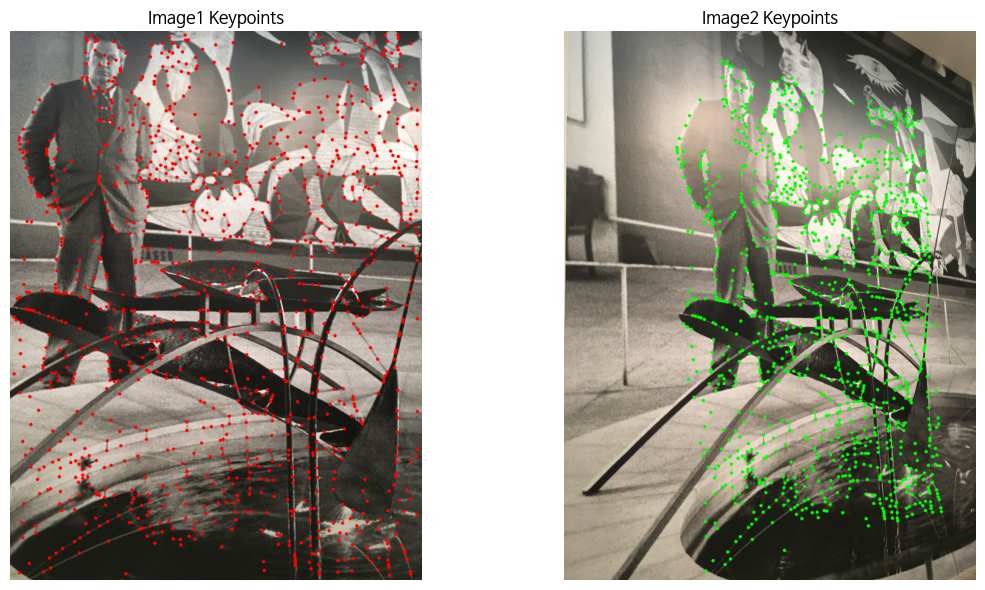

In [53]:
import cv2
import matplotlib.pyplot as plt

def visualize_keypoints(img1, kpts1, img2, kpts2, title1="Image1 Keypoints", title2="Image2 Keypoints"):
    draw1 = img1.copy()
    draw2 = img2.copy()

    for (x, y) in kpts1:
        cv2.circle(draw1, (int(x), int(y)), 3, (0, 0, 255), -1)
    
    for (x, y) in kpts2:
        cv2.circle(draw2, (int(x), int(y)), 3, (0, 255, 0), -1)
    
    draw1_rgb = cv2.cvtColor(draw1, cv2.COLOR_BGR2RGB)
    draw2_rgb = cv2.cvtColor(draw2, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(draw1_rgb)
    plt.title(title1)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(draw2_rgb)
    plt.title(title2)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
visualize_keypoints(img1, m_kpts0, img2, m_kpts1,
                    title1="Image1 Keypoints",
                    title2="Image2 Keypoints")

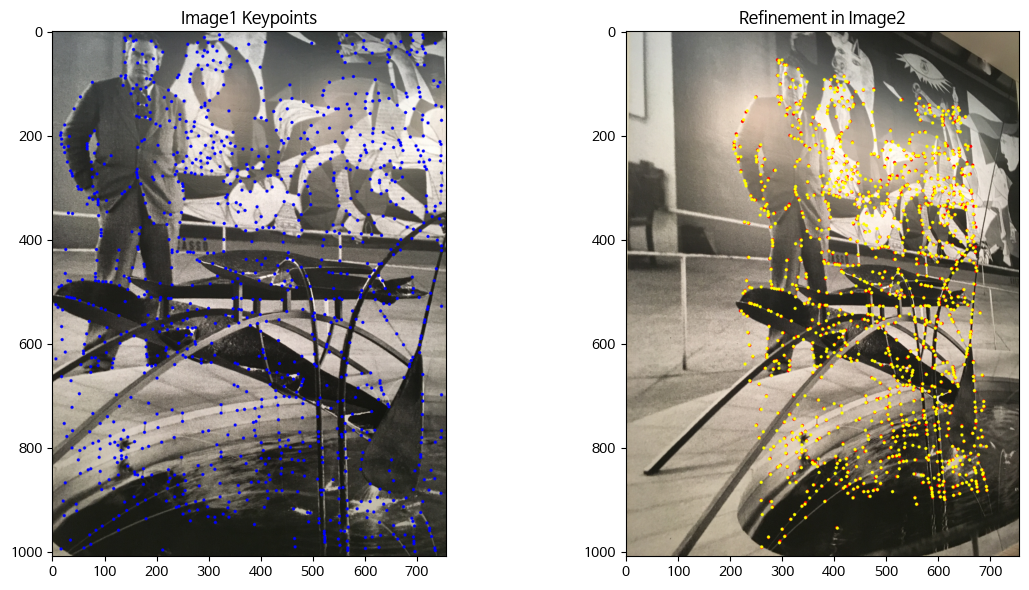

In [56]:
def visualize_refinement(img1, m_kpts0,
                         img2, m_kpts1, refined_kpts1,
                         patch_color=(255, 0, 0), 
                         refined_color=(0, 255, 255)):
    draw1 = img1.copy()
    draw2 = img2.copy()

    for (x, y) in m_kpts0:
        cv2.circle(draw1, (int(x), int(y)), 3, patch_color, -1)
    
    for (x, y) in m_kpts1:
        cv2.circle(draw2, (int(x), int(y)), 3, (0, 0, 255), -1)
    
    for (x, y) in refined_kpts1:
        cv2.circle(draw2, (int(x), int(y)), 3, refined_color, -1)

    draw1_rgb = cv2.cvtColor(draw1, cv2.COLOR_BGR2RGB)
    draw2_rgb = cv2.cvtColor(draw2, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(draw1_rgb)
    plt.title("Image1 Keypoints")

    plt.subplot(1, 2, 2)
    plt.imshow(draw2_rgb)
    plt.title("Refinement in Image2")

    plt.tight_layout()
    plt.savefig('keypoints_refine.png')

visualize_refinement(img1, m_kpts0, img2, m_kpts1, refined_kpts1)


In [81]:
import numpy as np

def compute_refinement_error(gt_kpts, refined_kpts):
    distances = np.linalg.norm(gt_kpts - refined_kpts, axis=1)
    mean_error = np.mean(distances)
    std_error  = np.std(distances)
    return mean_error, std_error


mean_err, std_err = compute_refinement_error(kpts1_gt, refined_kpts1)
print(f"Mean error: {mean_err:.2f} pixels, Std error: {std_err:.2f} pixels")
mean_err, std_err = compute_refinement_error(kpts1_gt, m_kpts1)
print(f"Mean error: {mean_err:.2f} pixels, Std error: {std_err:.2f} pixels")

Mean error: 0.90 pixels, Std error: 1.40 pixels
Mean error: 1.23 pixels, Std error: 1.49 pixels


In [55]:
img1.shape

(653, 986, 3)

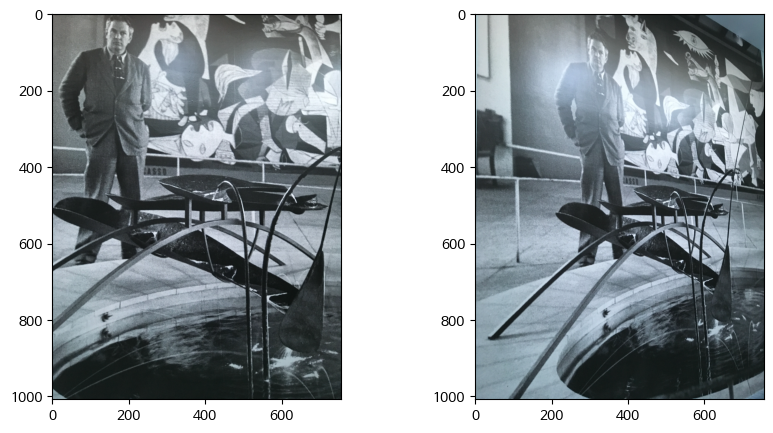

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1)
ax[1].imshow(img2)